In [1]:
import torch
from transformers import AutoModelForCausalLM

In [2]:
from know_subnet.lm.qwen import SelectivePrunedQwenLM
from know_subnet.lm.lm_utils import load_from_checkpoint
from know_subnet.args import get_args
import pickle

with open("args.pkl", "rb") as f:
    config = pickle.load(f).__dict__

print(config)
model = load_from_checkpoint(config, '/home/amit.vaisman/236004_transformers_project/logs/logs/-date=2025_07_23_11:47:38/checkpoints/ckpt-step=10-sparsity=1753260550', True)


# model = SelectivePrunedQwenLM(
#     out_w_per_mask,
#     in_w_per_mask, 
#     lm_name=config["lm"],
#     top_k_layers=config["top_k_layers"],
#     linear_types_to_mask=config["linear_types_to_mask"], 
#     module_types_to_mask=class_name_to_class(config['module_types_to_mask']),
#     use_dropout=config["use_dropout"],
#     initial_mask_p=config["initial_mask_p"],
#     top_limit=config["top_limit"],
#     bottom_limit=config["bottom_limit"],
#     verbose=verbose,
# )


# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model = SelectivePrunedQwenLM(model_name)

/home/amit.vaisman/miniconda3/envs/236004_transformers_project/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/amit.vaisman/miniconda3/envs/236004_transformers_project/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


{'exper_name': '', 'project_name': '', 'kg_type': 'wordnet', 'targetkg_name': "Synset('statement.n.01')", 'is_csqa': False, 'test_full_model': False, 'lm': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'use_dropout': False, 'initial_mask_p': 0.45, 'log_dir': 'logs', 'nfs_dir': '', 'date': '2025_07_23_13:09:24', 'seed': 42, 'lr': 5e-05, 'train_batch_size': 5, 'eval_batch_size': 5, 'train_epoch': 2, 'lr_warmup_frac': 0.1, 'log_step': 100, 'save_checkpoint_every': 200, 'verbose': True, 'lambda_reg_init': 2.0, 'lambda_reg_final': 3.0, 'mask_lr': 0.2, 'params': (1, 1), 'top_k_layers': 12, 'top_limit': -1, 'bottom_limit': -1, 'linear_types_to_mask': ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'], 'module_types_to_mask': [<class 'transformers.models.qwen2.modeling_qwen2.Qwen2Attention'>, <class 'transformers.models.qwen2.modeling_qwen2.Qwen2MLP'>, <class 'transformers.models.qwen2.modeling_qwen2.Qwen2DecoderLayer'>], 'include_controllm_loss': True, 'controllm_tra

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer

base_model = load_from_checkpoint(config, 'test.pt', True)
print(base_model)
base_model = base_model.to('cuda')

model = model.to('cuda')

model_name= 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
gsm8k = load_dataset("gsm8k", "main", split="train")
prompt = gsm8k[0]['question']

import torch.nn.functional as F

MAX_NEW_TOKENS = 100  # or however many you want

def prompt_model(model, tokenizer, prompt, device="cuda"):
    messages = [
        {"role": "system", "content": "Please reason step by step, and put your final answer within \\boxed{}."},
        {"role": "user", "content": prompt}
    ]

    # Apply chat template and tokenize
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    input_ids = model_inputs["input_ids"].to(device)

    # Start with the prompt
    generated = input_ids.clone().to(device)

    model.eval()
    with torch.no_grad():
        for _ in range(MAX_NEW_TOKENS):
            outputs = model(input_ids=generated)
            logits = outputs.logits  # shape: (batch_size, seq_len, vocab_size)
            next_token_logits = logits[:, -1, :]  # take last token logits

            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)  # shape: (batch_size, 1)
            generated = torch.cat((generated, next_token), dim=1)

            # Stop if all sequences hit the EOS token
            if tokenizer.eos_token_id is not None:
                if (next_token == tokenizer.eos_token_id).all():
                    break

    # Decode only the newly generated tokens (after the input prompt)
    new_tokens = generated[0, input_ids.shape[-1]:]
    decoded = tokenizer.decode(new_tokens, skip_special_tokens=True)
    return decoded

print(type(model))
tokenizer = AutoTokenizer.from_pretrained(model_name)
answer = prompt_model(base_model, tokenizer, prompt, device="cuda")
print(answer)
# prompt_model(model, tokenizer, gs

1 1
SelectivePrunedQwenLM(
  (lm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151936, 1536)
      (layers): ModuleList(
        (0-15): 16 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
            (k_proj): Linear(in_features=1536, out_features=256, bias=True)
            (v_proj): Linear(in_features=1536, out_features=256, bias=True)
            (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
            (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
            (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        

In [39]:

def print_maskedlinear_attributes(model):
    layer_names = []
    norms_list = []
    for name, module in model.named_modules():
        if module.__class__.__name__ == "MaskedLinear":  # check if it's MaskedLinear
            # print(f"\n--- MaskedLinear Layer: {name} ---")
            # print(f"In features: {module.in_features}")
            # print(f"Out features: {module.out_features}")
            # print(f"Bias: {module.bias is not None}")
            # print(f"Mask module: {module.mask.__class__.__name__}")

            # If the mask has parameters/attributes
            if hasattr(module.mask, '__dict__'):
                # print("Mask attributes:")
                print(module.mask.__dict__.items()[0]) # [1]['_parameters']['mask_scores']
                for attr, val in module.mask.__dict__.items():
                    if attr.startswith("_"):
                        if attr == '_parameters':
                            # print("Mask Scores")
                            mask_scores = val['mask_scores'].norm() / val['mask_scores'].numel()
                            layer_names.append(name)
                            norms_list.append(mask_scores.item())
                            # print(mask_scores)
                    else:
                        continue
                        # print(f"   {attr}: {val}")

        
    return layer_names, norms_list

layer_names, norms_list = print_maskedlinear_attributes(model)

import pandas as pd
df = pd.DataFrame({'layer_name' : layer_names, 'norm' : norms_list})
df['layer_number'] = df['layer_name'].apply(lambda x: x.split('.')[3])
df['layer_type'] = df['layer_name'].apply(lambda x: x.split('.')[-1])
df = df.pivot_table(index='layer_number', columns='layer_type', values='norm')

import seaborn as sns
sns.heatmap(df)
df

TypeError: 'dict_items' object is not subscriptable

In [3]:
for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Layer: {name}, shape: {param.data.shape}, mean abs: {param.data.abs().mean().item()}")

Layer: lm.model.embed_tokens.weight, shape: torch.Size([151936, 1536]), mean abs: 0.0228424072265625
Layer: lm.model.layers.0.self_attn.q_proj.weight, shape: torch.Size([1536, 1536]), mean abs: 0.03582763671875
Layer: lm.model.layers.0.self_attn.k_proj.weight, shape: torch.Size([256, 1536]), mean abs: 0.046112060546875
Layer: lm.model.layers.0.self_attn.v_proj.weight, shape: torch.Size([256, 1536]), mean abs: 0.02423095703125
Layer: lm.model.layers.0.self_attn.o_proj.weight, shape: torch.Size([1536, 1536]), mean abs: 0.034149169921875
Layer: lm.model.layers.0.mlp.gate_proj.weight, shape: torch.Size([8960, 1536]), mean abs: 0.0302276611328125
Layer: lm.model.layers.0.mlp.up_proj.weight, shape: torch.Size([8960, 1536]), mean abs: 0.027130126953125
Layer: lm.model.layers.0.mlp.down_proj.weight, shape: torch.Size([1536, 8960]), mean abs: 0.02886962890625
Layer: lm.model.layers.0.input_layernorm.weight, shape: torch.Size([1536]), mean abs: 0.216064453125
Layer: lm.model.layers.0.post_attent

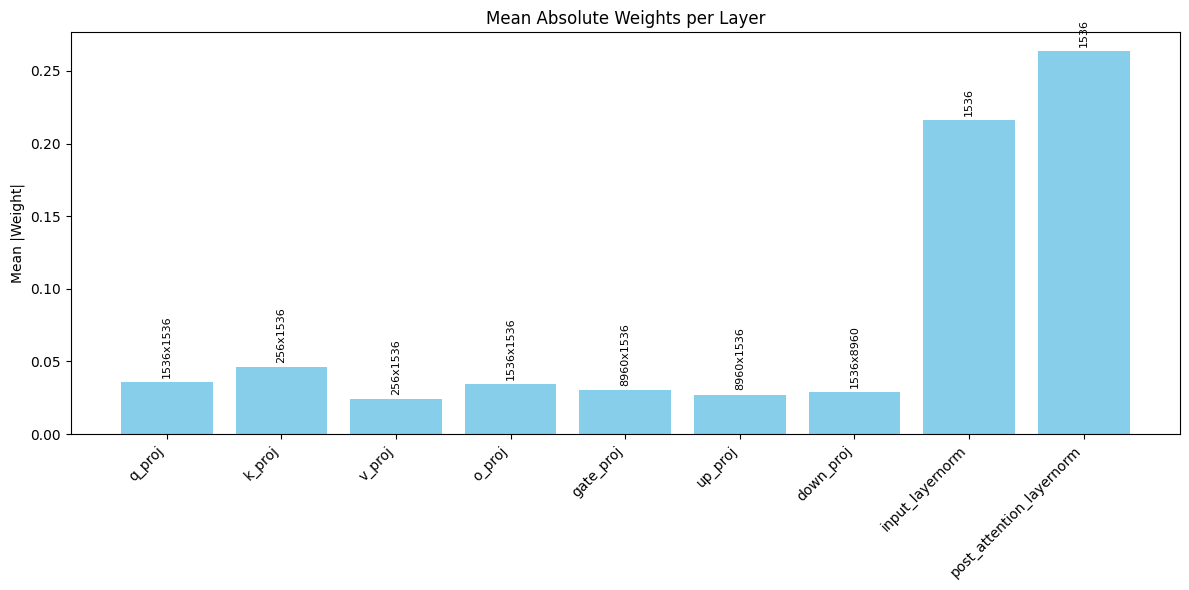

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from your output
layers = [
    "lm.model.layers.0.self_attn.q_proj.weight",
    "lm.model.layers.0.self_attn.k_proj.weight",
    "lm.model.layers.0.self_attn.v_proj.weight",
    "lm.model.layers.0.self_attn.o_proj.weight",
    "lm.model.layers.0.mlp.gate_proj.weight",
    "lm.model.layers.0.mlp.up_proj.weight",
    "lm.model.layers.0.mlp.down_proj.weight",
    "lm.model.layers.0.input_layernorm.weight",
    "lm.model.layers.0.post_attention_layernorm.weight"
]

means = [
    0.03582763671875,
    0.046112060546875,
    0.02423095703125,
    0.034149169921875,
    0.0302276611328125,
    0.027130126953125,
    0.02886962890625,
    0.216064453125,
    0.263427734375
]

shapes = [
    "1536x1536",
    "256x1536",
    "256x1536",
    "1536x1536",
    "8960x1536",
    "8960x1536",
    "1536x8960",
    "1536",
    "1536"
]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(layers)), means, color='skyblue')

ax.set_title("Mean Absolute Weights per Layer")
ax.set_xticks(range(len(layers)))
ax.set_xticklabels([l.split('.')[-2] for l in layers], rotation=45, ha="right")
ax.set_ylabel("Mean |Weight|")

# Add annotations with shapes
for bar, shape in zip(bars, shapes):
    height = bar.get_height()
    ax.annotate(
        shape,
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=8, rotation=90
    )

plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt
import torch

def plot_layer_weight_hist(model, layer_keyword="transformer.h.0.attn.c_attn.weight"):
    weights = None
    for name, param in model.named_parameters():
        if name == layer_keyword:
            weights = param.data.flatten().cpu()
            break
    
    if weights is not None:
        plt.hist(weights.numpy(), bins=100, alpha=0.7)
        plt.title(f"Weight distribution: {layer_keyword}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print(f"Layer {layer_keyword} not found!")

plot_layer_weight_hist(model, "transformer.h.0.attn.c_attn.weight")

Layer transformer.h.0.attn.c_attn.weight not found!


In [ ]:
import numpy as np

layer_names = []
layer_means = []

for name, param in model.named_parameters():
    if "weight" in name and "transformer.h." in name:  # focus on transformer layers
        layer_names.append(name)
        layer_means.append(param.data.abs().mean().item())

plt.figure(figsize=(10, 6))
plt.barh(layer_names, layer_means)
plt.xlabel("Mean |weight|")
plt.ylabel("Layer")
plt.title("Layer-wise weight magnitudes")
plt.tight_layout()
plt.show()

In [ ]:
for name, param in model.named_parameters():
    if "weight" in name:
        zero_ratio = (param.data == 0).float().mean().item()
        print(f"Layer: {name}, sparsity: {100 * zero_ratio:.2f}%")


In [ ]:
import os

top_dict = {'step' : [], 'mask_scores' : [], 'layer_nums' : [], 'layer_types' : []}

directory = "logs/logs/-date=2025_07_23_14:28:29/checkpoints/"
# Loop through all files in the directory
for file_name in os.listdir(directory):
    print(file_name)
    # if file_name.endswith(".pt") or file_name.endswith(".pth"):
    key = os.path.splitext(file_name)[0]  # Use file name (without extension) as column name
    tensor_path = os.path.join(directory, file_name)
    
    tensor = torch.load(tensor_path)
    tensor['mask_scores'] = [ torch.sigmoid(tens).detach().mean().item() for tens in tensor['mask_scores'] ]
    
    for key in tensor.keys():
        if key == 'step':
            curr_len = len(tensor['mask_scores'])
            top_dict[key] += curr_len * [tensor['step']]
            continue
            
        top_dict[key] += tensor[key]
        
# Create DataFrame


10
20
30
40
50
60
70
80
90
100
110
120
130
140


/home/amit.vaisman/miniconda3/envs/236004_transformers_project/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/amit.vaisman/miniconda3/envs/236004_transformers_project/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/amit.vaisman/miniconda3/envs/236004_transformers_project/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

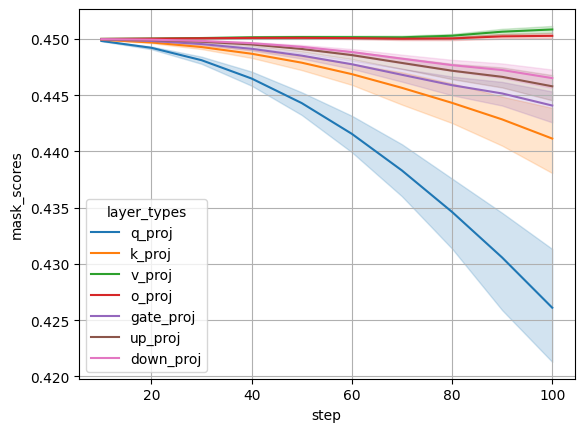

In [91]:
import matplotlib.pyplot as plt
df = pd.DataFrame(top_dict)
sns.lineplot(df, x='step', y='mask_scores', hue='layer_types')
plt.grid('--')
plt.show()